# Import module, packages

In [3]:
!pip install iPython_SQL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
import pandas as pd
import os
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import csv, sqlite3

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# 1. Business Understanding and Analytic Approach

•	Mục tiêu: Phân tích giá bất động sản tại các thành phố lớn như New York, Los Angeles, và Chicago. Mục tiêu là so sánh sự khác biệt về giá giữa các khu vực này và phân tích các yếu tố ảnh hưởng đến giá.  
•	Tiếp cận: Tập trung thu thập dữ liệu từ các trang bất động sản và thực hiện phân tích so sánh giá giữa các loại hình bất động sản trong thành phố  



# 2. Data Collection, Understanding, Preparation

### Dataset: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [3]:
df_LasVegas = pd.read_csv('Las Vegas.csv')
df_Miami = pd.read_csv('Miami.csv')
df_SanFrancisco = pd.read_csv('SanFrancisco.csv')
df = pd.concat([df_LasVegas, df_Miami, df_SanFrancisco], ignore_index=True)

### Data Cleaning

In [4]:
df

,city,state,house_size,bed,bath,price
0,Las Vegas,New Mexico,NaN,NaN,NaN,50000.0
1,Las Vegas,New Mexico,NaN,NaN,NaN,50000.0
2,Las Vegas,New Mexico,NaN,NaN,NaN,50000.0
3,Las Vegas,New Mexico,NaN,NaN,NaN,50000.0
4,Las Vegas,New Mexico,NaN,NaN,NaN,135000.0
...,...,...,...,...,...,...
17757,San Francisco,California,2290.0,5.0,3.0,2200000.0
17758,San Francisco,California,2508.0,5.0,4.0,2745000.0
17759,San Francisco,California,2078.0,3.0,3.0,1775000.0
17760,San Francisco,California,1380.0,2.0,1.0,1295000.0


In [5]:
# 1.Xử lý null

In [6]:
df.isnull().sum()

city             0
state            0
house_size    1402
bed           1239
bath          1621
price            0
dtype: int64

In [7]:
df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
df.isnull().sum()

city          0
state         0
house_size    0
bed           0
bath          0
price         0
dtype: int64

In [8]:
# 2. Thêm thông tin cho dataset

In [9]:
bins = [0, 2000000, 5000000, 10000000, 50000000, 100000000, 200000000]
labels = ['0-2M', '2M-5M', '5M-10M', '10M-50M', '50M-100M', '100M-200M']

# Chia dữ liệu 'price' vào các khoảng
df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels)

In [10]:
df.dtypes

city             object
state            object
house_size      float64
bed             float64
bath            float64
price           float64
price_range    category
dtype: object

# 3. Data Analysis with SQL

In [11]:
con = sqlite3.connect("HouseData.db")
cur = con.cursor()

In [12]:
#Kích Hoạt SQL Magic
%load_ext sql

In [13]:
# Cho phép SQL Magic kết nối với CSDL
%sql sqlite:///HouseData.db

In [14]:
# Import DataFrame vào cơ sở dữ liệu
df.to_sql('BigCity', con, if_exists='replace', index=False)

15106

In [15]:
%%sql
SELECT *
FROM BigCity
WHERE [house_size] >= 20000;


 * sqlite:///HouseData.db
Done.


city,state,house_size,bed,bath,price,price_range
Las Vegas,Nevada,21835.0,11.0,16.0,10775000.0,10M-50M
Las Vegas,Nevada,26739.0,14.0,18.0,5495000.0,5M-10M
Las Vegas,Nevada,20558.0,7.0,12.0,8250000.0,5M-10M
San Francisco,California,20000.0,8.0,13.0,29500000.0,10M-50M


In [16]:
con.close()

# 4. Data Analysis with Python

### Phân tích giá nhà tại các khu du lịch

1.	Giá trị trung bình (mean).
2.	Trung vị (median).
3.	Độ lệch chuẩn (std).
4.	Giá trị nhỏ nhất (min).
5.	Giá trị lớn nhất (max).
6.	Phân vị thứ 25% (25% quantile).
7.	Phân vị thứ 75% (75% quantile).

In [17]:
stats = df.describe()
print("Thống kê mô tả tổng quát cho bất động sản:")
stats

Thống kê mô tả tổng quát cho bất động sản:


,house_size,bed,bath,price
count,15106.000000,15106.000000,15106.000000,1.510600e+04
mean,1723.417053,2.779293,2.435125,1.033478e+06
std,1190.545274,1.332609,1.262053,1.968939e+06
min,259.000000,1.000000,1.000000,1.499500e+04
25%,1036.000000,2.000000,2.000000,3.999990e+05
50%,1417.500000,3.000000,2.000000,6.490000e+05
75%,2010.000000,3.000000,3.000000,1.150000e+06
max,26739.000000,30.000000,30.000000,1.500000e+08


In [18]:
# 8. Độ biến thiên giá theo khu vực
price_variance_by_location = df.groupby('city')['price'].var()
price_variance_by_location

city
Las Vegas        1.397707e+12
Miami            4.763588e+12
San Francisco    3.172021e+12
Name: price, dtype: float64

In [19]:
# 9. Số lượng bất động sản theo từng khu vực
count_by_province = df['city'].value_counts()
count_by_province

city
Miami            8663
San Francisco    3556
Las Vegas        2887
Name: count, dtype: int64

In [20]:
# 10. Hệ số biến thiên giá (coefficient of variation)
cv = df['price'].std() / df['price'].mean()
cv

1.9051589008122314

Hệ số biến thiên 190%: Cho thấy mức độ phân tán của giá nhà rất ở các thành phố du lịch tại Mỹ

In [21]:
# 11. Độ lệch trung bình tuyệt đối (mean absolute deviation)
price_data = df['price']
mean_price = price_data.mean()
mad = (price_data - mean_price).abs().mean()

print("Mean Absolute Deviation (MAD):", mad)

Mean Absolute Deviation (MAD): 733705.6703178907


In [22]:
# 12. Độ phân tán của giá (range)
price_range = df['price'].max() - df['price'].min()
price_range

149985005.0

In [23]:
# 13. Phân tích ngoại lệ (outliers) - sử dụng IQR (Interquartile Range)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
outliers
#outliers.sort_values(by='price', inplace=True, ascending=True)

,city,state,house_size,bed,bath,price,price_range
25,Las Vegas,Nevada,5110.0,5.0,7.0,3000000.0,2M-5M
52,Las Vegas,Nevada,4414.0,4.0,5.0,2950000.0,2M-5M
75,Las Vegas,Nevada,6104.0,5.0,5.0,3250000.0,2M-5M
76,Las Vegas,Nevada,5750.0,4.0,5.0,6750000.0,5M-10M
88,Las Vegas,Nevada,10633.0,8.0,10.0,5895000.0,5M-10M
...,...,...,...,...,...,...,...
15087,San Francisco,California,2766.0,4.0,5.0,3599950.0,2M-5M
15088,San Francisco,California,3427.0,4.0,4.0,3995000.0,2M-5M
15090,San Francisco,California,2322.0,4.0,3.0,2695000.0,2M-5M
15102,San Francisco,California,2508.0,5.0,4.0,2745000.0,2M-5M


In [24]:
# 14. Phân tích tần suất xuất hiện của giá (frequency analysis)
price_frequency = df['price_range'].value_counts()
price_frequency

price_range
0-2M         13807
2M-5M         1056
5M-10M         176
10M-50M         66
100M-200M        1
50M-100M         0
Name: count, dtype: int64

In [25]:
# 15. Hệ số tương quan giữa giá và diện tích bất động sản
corr_price_area = df['price'].corr(df['house_size'])
corr_price_area

0.5601676974487632

Hệ số tương quan ~ 0.56 --> Có một mối quan hệ tương quan nhất định

In [26]:
# 16. Hệ số tương quan giữa giá và số phòng ngủ
corr_price_bedroom = df['price'].corr(df['bed'])
corr_price_bedroom

0.270538208419802

In [27]:
# 17. Phân tích sự khác biệt giá giữa các vùng (giá trung bình giữa các vùng)
mean_price_by_location = df.groupby('city')['price'].mean()
mean_price_by_location.sort_values(ascending=False)

city
San Francisco    1.686162e+06
Miami            8.434401e+05
Las Vegas        7.997924e+05
Name: price, dtype: float64

In [28]:
# 18. Đánh giá mức độ phân tán giá
price_dispersion = df['price'].std() / df['price'].mean()
price_dispersion

1.9051589008122314

In [29]:
# 19. Giá trị ngoại lệ trên và dưới (dùng IQR như phần trên)
outliers_upper = df[df['price'] > (Q3 + 1.5 * IQR)]
outliers_lower = df[df['price'] < (Q1 - 1.5 * IQR)]
print(f'Outliers upper: {outliers_upper}')
print(f'Outliers lower: {outliers_lower}')

Outliers upper:                 city       state  house_size  bed  bath      price price_range
25         Las Vegas      Nevada      5110.0  5.0   7.0  3000000.0       2M-5M
52         Las Vegas      Nevada      4414.0  4.0   5.0  2950000.0       2M-5M
75         Las Vegas      Nevada      6104.0  5.0   5.0  3250000.0       2M-5M
76         Las Vegas      Nevada      5750.0  4.0   5.0  6750000.0      5M-10M
88         Las Vegas      Nevada     10633.0  8.0  10.0  5895000.0      5M-10M
...              ...         ...         ...  ...   ...        ...         ...
15087  San Francisco  California      2766.0  4.0   5.0  3599950.0       2M-5M
15088  San Francisco  California      3427.0  4.0   4.0  3995000.0       2M-5M
15090  San Francisco  California      2322.0  4.0   3.0  2695000.0       2M-5M
15102  San Francisco  California      2508.0  5.0   4.0  2745000.0       2M-5M
15105  San Francisco  California      6962.0  7.0   5.0  6995000.0      5M-10M

[1123 rows x 7 columns]
Outliers lo

In [30]:
# 20. Sự phân phối giá qua các phân vị
price_quantiles = df['price'].quantile([0.25, 0.5, 0.75, 1.0])
price_quantiles

0.25       399999.0
0.50       649000.0
0.75      1150000.0
1.00    150000000.0
Name: price, dtype: float64

# 5. Data Visualization

In [31]:
df.head(5)

,city,state,house_size,bed,bath,price,price_range
0,Las Vegas,New Mexico,1200.0,3.0,2.0,120000.0,0-2M
1,Las Vegas,New Mexico,2432.0,4.0,3.0,165000.0,0-2M
2,Las Vegas,New Mexico,1200.0,2.0,1.0,129000.0,0-2M
3,Las Vegas,New Mexico,1680.0,2.0,2.0,275000.0,0-2M
4,Las Vegas,New Mexico,2738.0,4.0,3.0,360000.0,0-2M


In [59]:
#1.	Bar Plot: So sánh giá trung bình giữa các thành phố du lịch tại Mỹ.

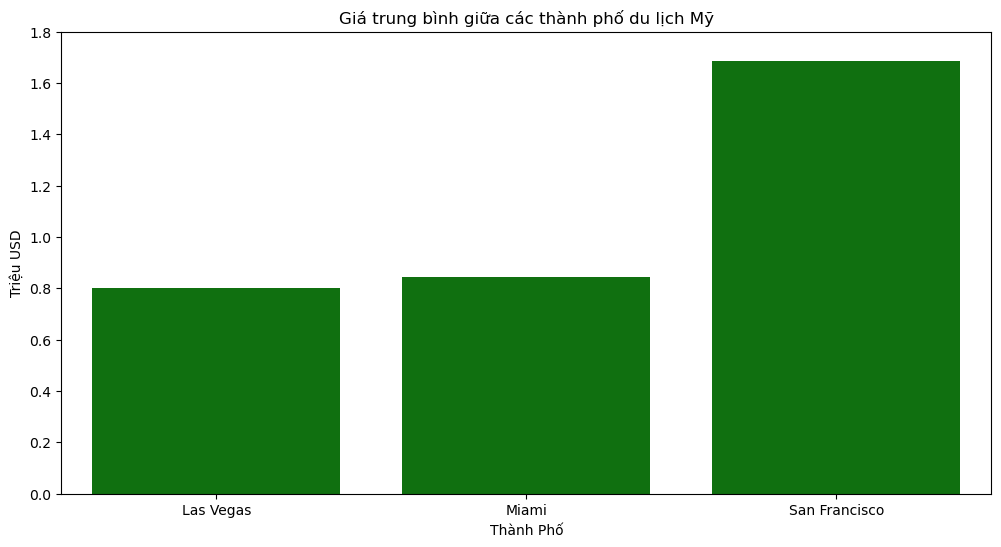

In [60]:
average_province = df.groupby('city')['price'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=average_province.index, y=average_province.values, color='Green')

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Giá trung bình giữa các thành phố du lịch Mỹ')
plt.xlabel('Thành Phố')
plt.ylabel('Triệu USD');

In [34]:
# 2. Box Plot: Hiển thị phân phối giá ở các vùng khác nhau.

9


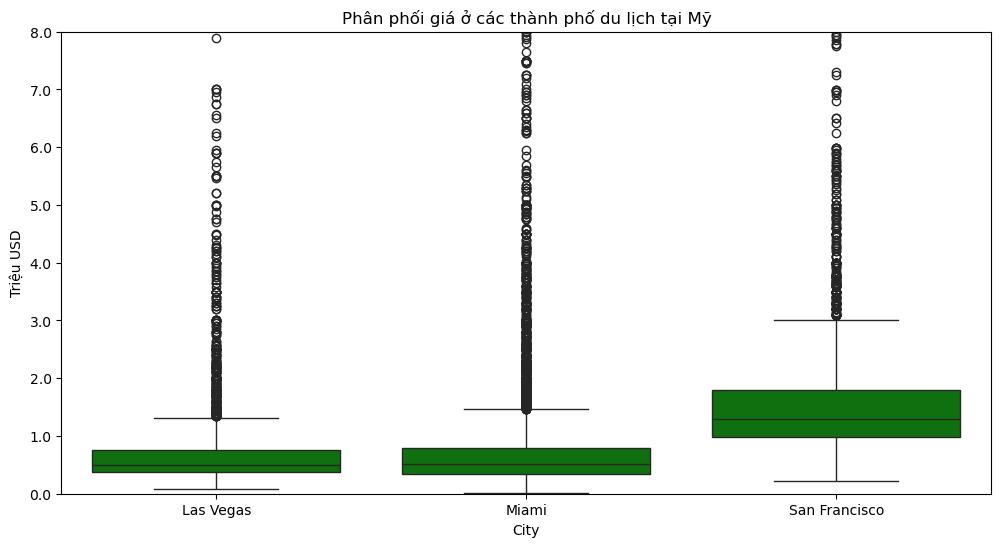

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df, color='Green')

plt.ylim(0, 8000000)
yticks = plt.yticks()[0]
print(len(yticks))
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Phân phối giá ở các thành phố du lịch tại Mỹ')
plt.xlabel('City')
plt.ylabel('Triệu USD');

In [36]:
#3. Violin Plot: Phân tích sự phân tán giá.

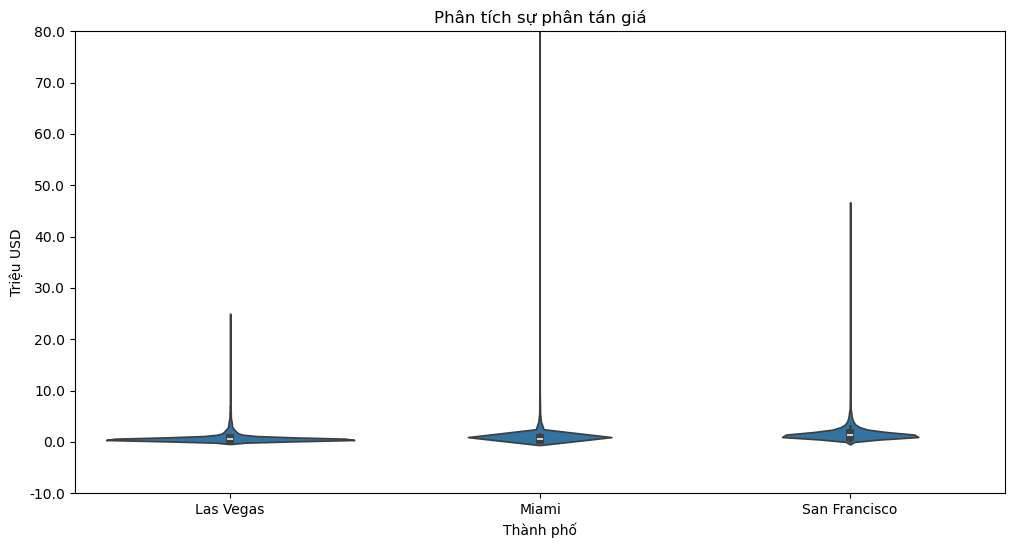

In [37]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='city', y='price', data=df)

plt.ylim(-1000000, 75000000)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Phân tích sự phân tán giá')
plt.xlabel('Thành phố')
plt.ylabel('Triệu USD');


In [38]:
# 4.Scatter Plot: Quan hệ giữa giá và số phòng ngủ.

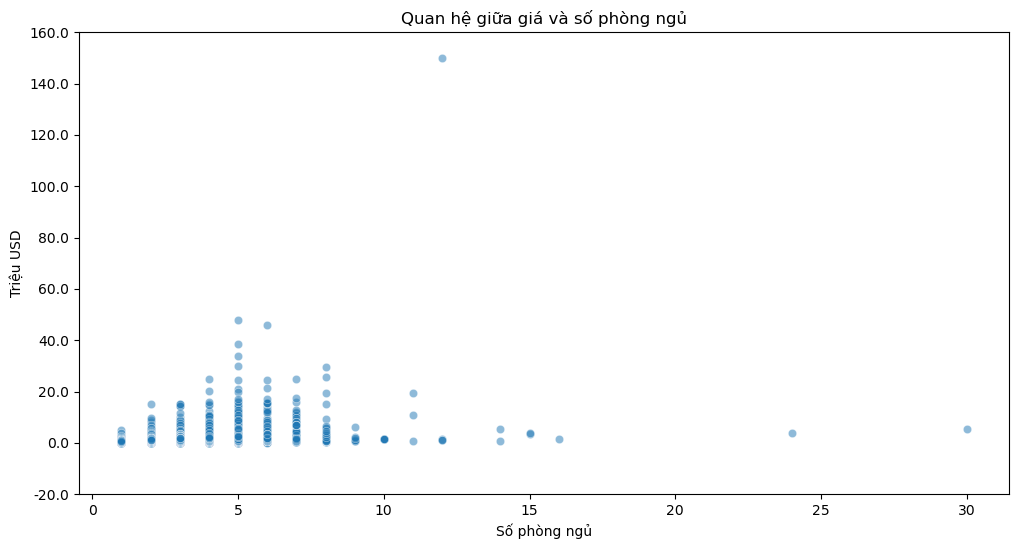

In [39]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bed', y='price', data=df, alpha=0.5)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Triệu USD');

In [40]:
# 6.Pie Chart: Phân bố số lượng bất động sản theo khu vực.

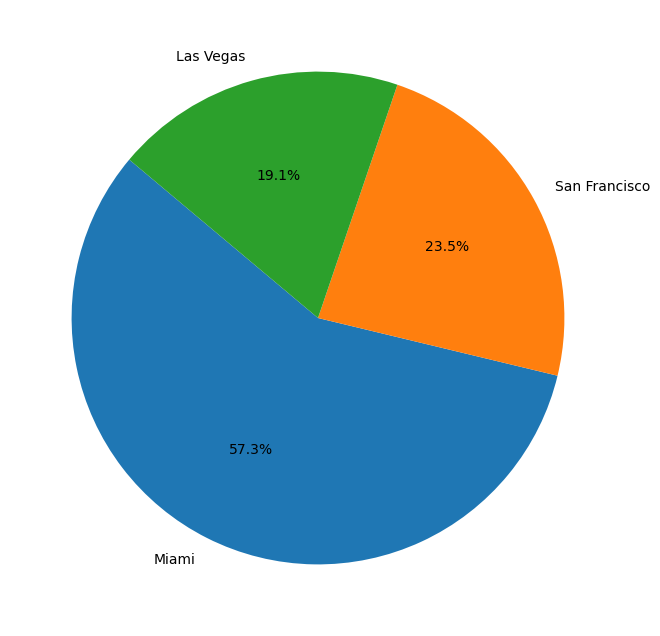

In [41]:
real_estate_counts = df['city'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(real_estate_counts, labels=real_estate_counts.index, autopct='%1.1f%%', startangle=140);

In [42]:
# Histogram: Phân phối giá của bất động sản.

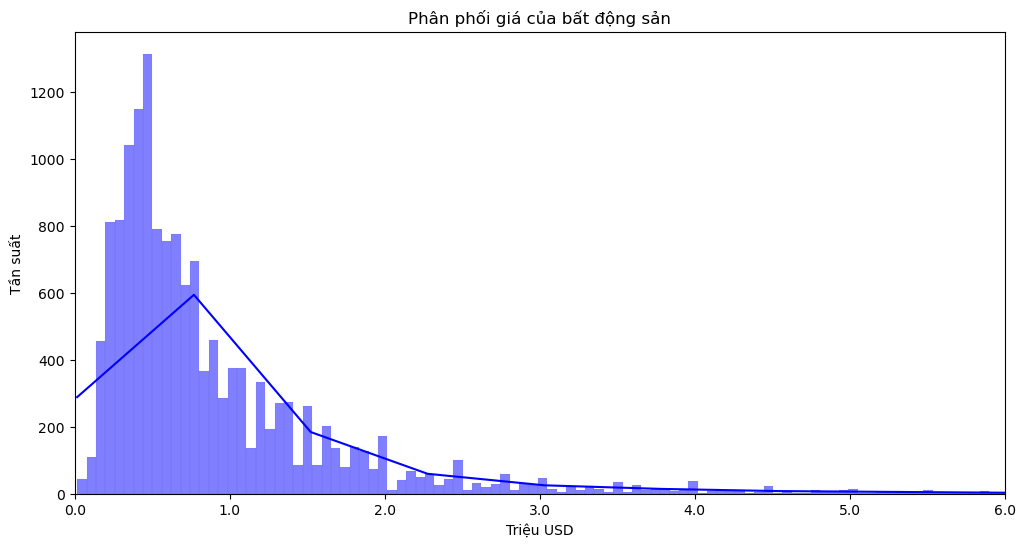

In [63]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, color='blue')

plt.xlim(0, 6000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in xticks])

plt.title('Phân phối giá của bất động sản')
plt.xlabel('Triệu USD')
plt.ylabel('Tần suất');

In [44]:
# Histogram: Phân phối tích lũy giá nhà

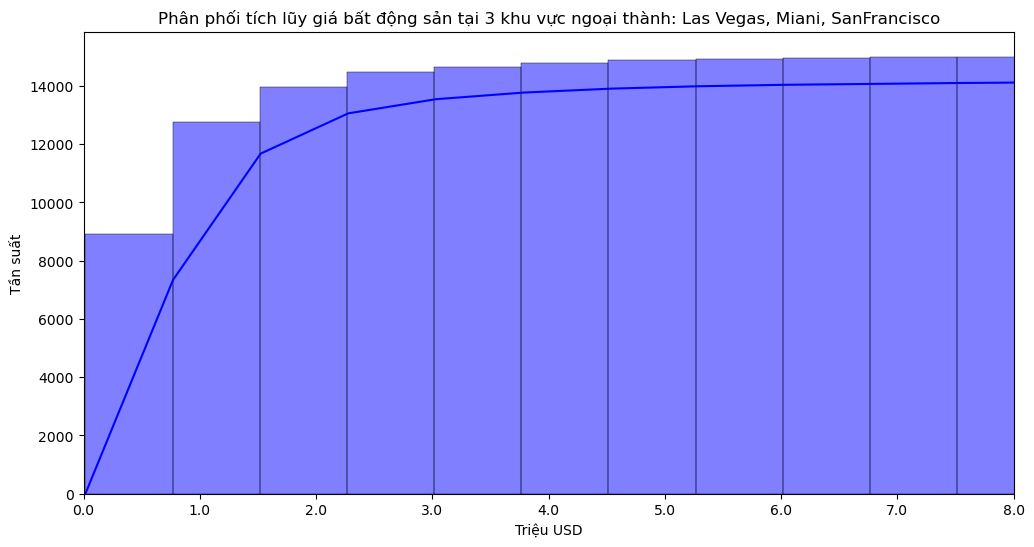

In [64]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, color='blue', cumulative=True, bins=200)

plt.xlim(0, 8000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in xticks])

plt.title('Phân phối tích lũy giá bất động sản tại 3 khu vực ngoại thành: Las Vegas, Miani, SanFrancisco')
plt.xlabel('Triệu USD')
plt.ylabel('Tần suất');

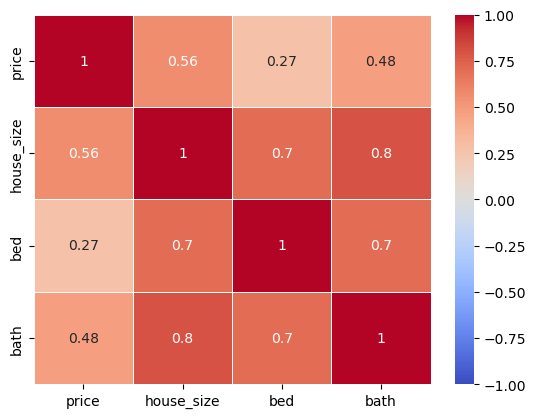

In [46]:
# Heatmap: Tương quan giữa giá và các yếu tố khác.
corr_matrix = df[['price', 'house_size', 'bed', 'bath']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5);

In [47]:
# Pair Plot: Tương quan giữa các biến số khác nhau.

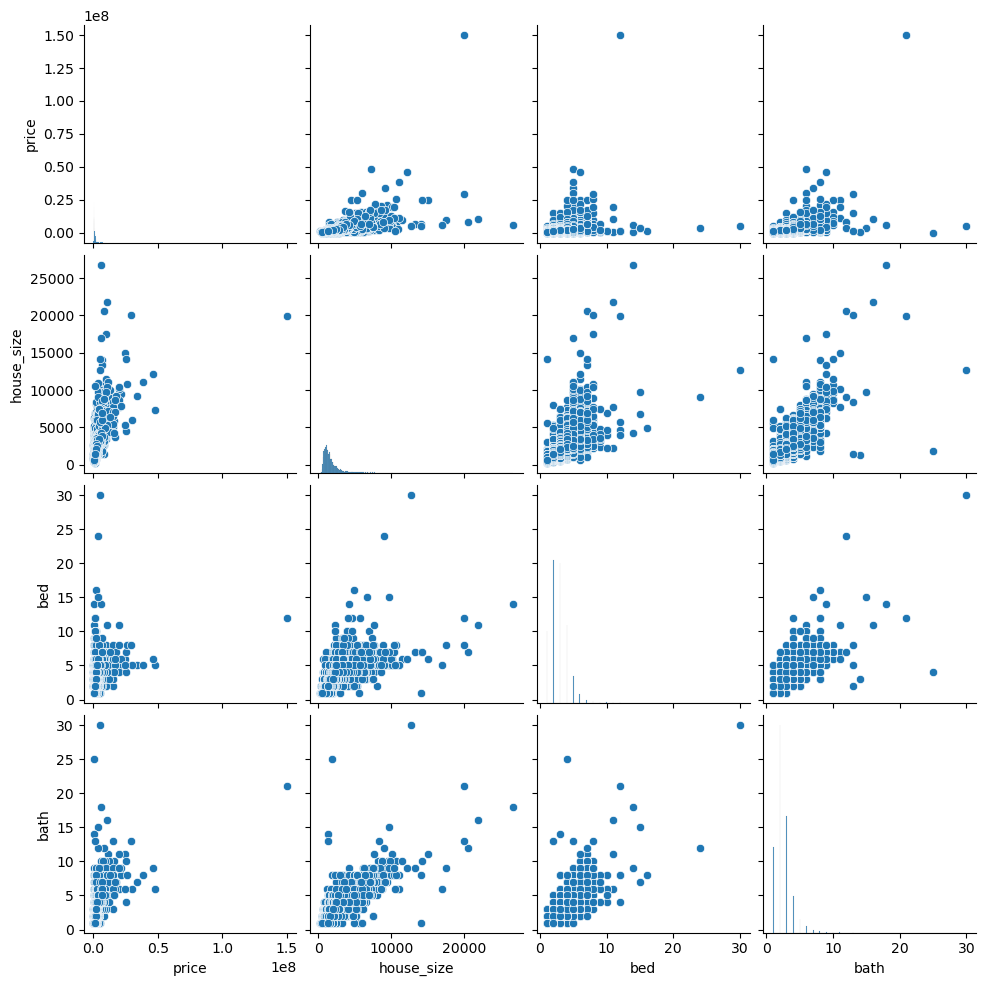

In [48]:
sns.pairplot(df[['price', 'house_size', 'bed', 'bath']]);

In [49]:
# Density Plot

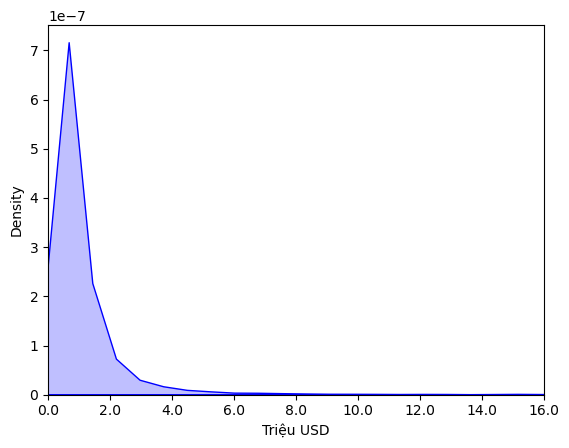

In [50]:
sns.kdeplot(df['price'], color='blue', fill=True)

plt.xlim(0, 15000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in xticks])

plt.xlabel('Triệu USD');

In [51]:
# Area Plot: Hiển thị xu hướng giá.

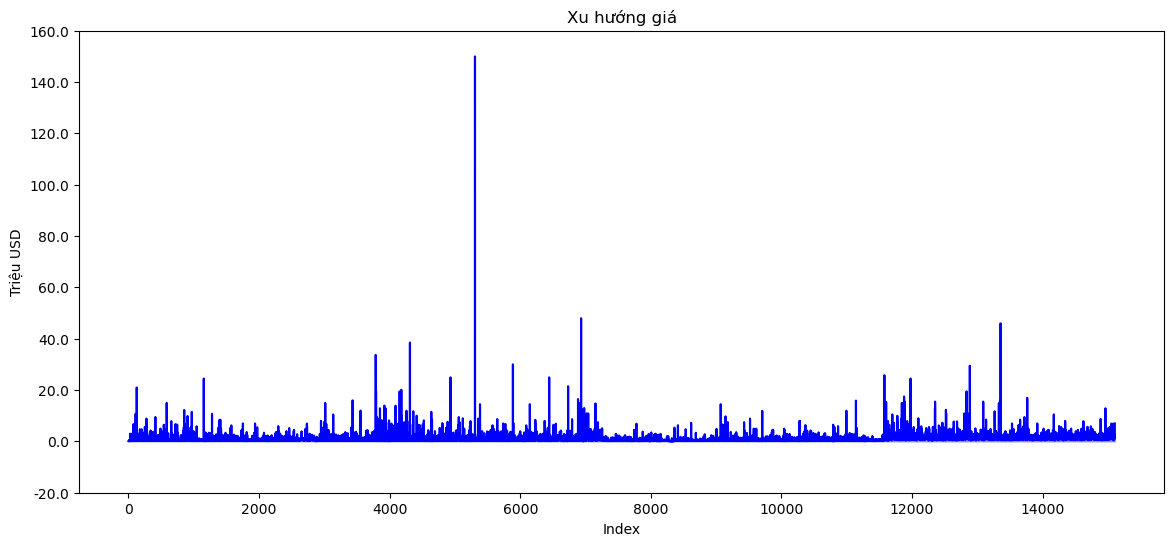

In [52]:
plt.figure(figsize=(14,6))

sns.lineplot(data=df['price'], color='blue')
plt.fill_between(df.index, df['price'], color='blue', alpha=0.3)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Xu hướng giá')
plt.xlabel('Index')
plt.ylabel('Triệu USD');

In [53]:
# Biểu đồ bong bóng của giá bất động sản theo diện tích

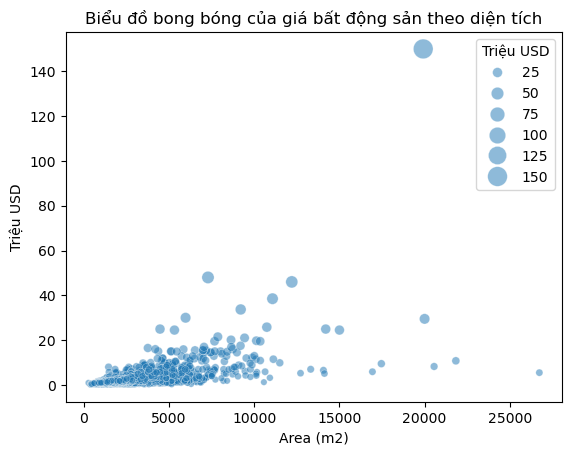

In [65]:
price_million = df['price'].apply(lambda x: x/(10**6))

sns.scatterplot(x=df.house_size, y=price_million, size=price_million, sizes=(20, 200), alpha=0.5)

plt.title('Biểu đồ bong bóng của giá bất động sản theo diện tích')
plt.xlabel('Area (m2)')
plt.ylabel('Triệu USD')

plt.legend(title='Triệu USD', fontsize='10');

# 6. Regression Analysis

In [55]:
# Huấn luyện mô hình
df['city_encoded'] = LabelEncoder().fit_transform(df['city'])
X = df[['house_size', 'bed', 'bath', 'city_encoded']]
Y = df[['price']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)
price_predictions = model.predict(X_test)

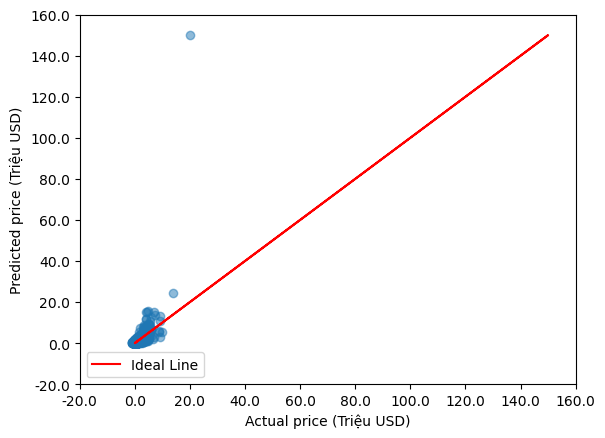

In [56]:
# Visualize khả năng dự đoán
plt.scatter(x=price_predictions, y=Y_test.values, alpha=0.5)
plt.plot(Y_test.values, Y_test.values, color='red', label='Ideal Line')

plt.ylabel('Predicted price (Triệu USD)')
plt.xlabel('Actual price (Triệu USD)')
plt.legend()

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in xticks])

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks]);

In [57]:
# Đánh giá hiệu suất model

In [58]:
mse = mean_squared_error(Y_test, price_predictions)
mae = mean_absolute_error(Y_test, price_predictions)
r2 = r2_score(Y_test, price_predictions)
intercept = model.intercept_  
coefficients = model.coef_   

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² score: {r2}")
print(f"Intercept (β0 - Hằng số): {intercept}")
print(f"Hệ số hồi quy (β1, β2, β3,...): {coefficients}")

Mean Squared Error (MSE): 6297835111903.092
Mean Absolute Error (MAE): 495012.8690377638
R² score: 0.3060232541836655
Intercept (β0 - Hằng số): [-1196820.34974841]
Hệ số hồi quy (β1, β2, β3,...): [[    928.26941126 -315774.56441279  270359.97594485  804580.92061897]]


# 7. Data Analysis with Tool

In [66]:
#df.to_csv('tourism_city_dataset.csv')